In [1]:
import duckdb
import polars as pl

# Read the data

In [2]:
current = duckdb.sql("from read_csv_auto('data/callcenterdatacurrent.csv')").pl()
historical = duckdb.sql("from read_csv_auto('data/callcenterdatahistorical.csv')").pl()
total = pl.concat([historical, current])

# Counting

## Most popular titles?

In [3]:
# current

(
    duckdb.sql("""
    select title, count(*) as n
    from current
    group by all
    order by 2 desc
    """)
)

┌───────────────────────────────────────────────────────┬───────┐
│                         TITLE                         │   n   │
│                        varchar                        │ int64 │
├───────────────────────────────────────────────────────┼───────┤
│ Christmas Tree Pickup                                 │   155 │
│ Street Light Out                                      │   139 │
│ Area Dark                                             │   115 │
│ Potholes                                              │    92 │
│ Missed Collection: Recycling                          │    88 │
│ Missed Collection: Garbage                            │    88 │
│ Scattered Litter and Debris on Private Property       │    72 │
│ Snow Plow Request                                     │    65 │
│ Bulky Pickup & San Inspector Notification             │    64 │
│ Sidewalks Not Shoveled (adjacent to Private Property) │    46 │
│           ·                                           │     · │
│         

It makes sense that a lot of tickets would be about Christmas tree pickups around the time of the "current" period, but it's important to note that "street light out", "dark areas", "potholes", and "missed collections" are frequent calls in this period.

In [4]:
# historical

(
    duckdb.sql("""
    select title, count(*) as n
    from historical
    group by all
    order by 2 desc
    """)
)

┌───────────────────────────────────────────────────────────────┬───────┐
│                             TITLE                             │   n   │
│                            varchar                            │ int64 │
├───────────────────────────────────────────────────────────────┼───────┤
│ Brush Pickup Request, Less than 2 Cubic Yards, April-November │ 11104 │
│ Parking Violations Information                                │  7296 │
│ Street Light Out                                              │  4669 │
│ Missed Collection: Garbage                                    │  4556 │
│ Pothole                                                       │  4002 │
│ Missed Collection: Recycling                                  │  3997 │
│ Weeds and Tall Grass Complaint                                │  3838 │
│ Area Dark                                                     │  3763 │
│ Miscellaneous Information Request                             │  3745 │
│ Sanitation Inspector Notification   

We see a lot of the same issues historically, but we can see that parking violations and brush pickup requests must occur more outside of the current period.

## Which titles have been increasing the most over time?

In [32]:
query = """
WITH title_counts_by_period AS (
  -- Create time buckets (e.g., by month) and count titles in each bucket
  SELECT 
    DATE_TRUNC('month', CREATIONDATE) AS period,
    TITLE,
    COUNT(*) AS title_count
  FROM total
  GROUP BY DATE_TRUNC('month', CREATIONDATE), TITLE
),

title_growth AS (
  -- Calculate growth rate for each title between consecutive periods
  SELECT
    TITLE,
    period,
    title_count,
    LAG(title_count) OVER (PARTITION BY TITLE ORDER BY period) AS prev_period_count,
    (title_count - LAG(title_count) OVER (PARTITION BY TITLE ORDER BY period)) AS absolute_growth,
    CASE 
      WHEN LAG(title_count) OVER (PARTITION BY TITLE ORDER BY period) > 0 
      THEN (title_count - LAG(title_count) OVER (PARTITION BY TITLE ORDER BY period)) / LAG(title_count) OVER (PARTITION BY TITLE ORDER BY period) 
      ELSE NULL 
    END AS percentage_growth
  FROM title_counts_by_period
),

title_overall_growth AS (
  -- Calculate overall growth for each title across the entire time range
  SELECT
    TITLE,
    FIRST_VALUE(title_count) OVER (PARTITION BY TITLE ORDER BY period) AS first_period_count,
    LAST_VALUE(title_count) OVER (PARTITION BY TITLE ORDER BY period ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS last_period_count,
    LAST_VALUE(title_count) OVER (PARTITION BY TITLE ORDER BY period ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) - 
      FIRST_VALUE(title_count) OVER (PARTITION BY TITLE ORDER BY period) AS absolute_overall_growth,
    CASE 
      WHEN FIRST_VALUE(title_count) OVER (PARTITION BY TITLE ORDER BY period) > 0 
      THEN (LAST_VALUE(title_count) OVER (PARTITION BY TITLE ORDER BY period ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) - 
           FIRST_VALUE(title_count) OVER (PARTITION BY TITLE ORDER BY period)) / FIRST_VALUE(title_count) OVER (PARTITION BY TITLE ORDER BY period)
      ELSE NULL 
    END AS percentage_overall_growth
  FROM title_counts_by_period
)

-- Get the titles with the highest growth
SELECT DISTINCT
  TITLE,
  first_period_count,
  last_period_count,
  absolute_overall_growth,
  percentage_overall_growth
FROM title_overall_growth
ORDER BY percentage_overall_growth DESC, absolute_overall_growth DESC
LIMIT 10;
"""

In [8]:
duckdb.sql(query).pl()

TITLE,first_period_count,last_period_count,absolute_overall_growth,percentage_overall_growth
str,i64,i64,i64,f64
"""Election Information""",2,572,570,285.0
"""Snow Plow Request""",1,65,64,64.0
"""Street Light Out""",1,64,63,63.0
"""Sidewalks Not Shoveled (adjace…",1,45,44,44.0
"""Scattered Litter and Debris on…",1,25,24,24.0
"""Christmas Tree Pickup""",7,155,148,21.142857
"""Leaf Disposal Info Request""",8,132,124,15.5
"""Garbage Cart: Damaged""",1,7,6,6.0
"""Sanitation Inspector Notificat…",4,24,20,5.0


We can see that queries for "election information", "snow plow requests", and "street lights out" are more common now than they were in previous periods so it is important to know have the election information easily accessible during this time and to have a snow plow crew ready.

### Which titles have seasonality to them?

In [9]:
query = """WITH monthly_counts AS (
  -- Get monthly counts for each title
  SELECT 
    TITLE,
    EXTRACT(YEAR FROM CREATIONDATE) AS year,
    EXTRACT(MONTH FROM CREATIONDATE) AS month,
    COUNT(*) AS title_count
  FROM total
  GROUP BY TITLE, EXTRACT(YEAR FROM CREATIONDATE), EXTRACT(MONTH FROM CREATIONDATE)
),

monthly_averages AS (
  -- Calculate the average count for each month across all years
  SELECT
    TITLE,
    month,
    AVG(title_count) AS avg_monthly_count
  FROM monthly_counts
  GROUP BY TITLE, month
),

title_monthly_stats AS (
  -- Calculate statistics to help identify seasonality
  SELECT
    TITLE,
    STDDEV(avg_monthly_count) AS monthly_stddev,
    MAX(avg_monthly_count) - MIN(avg_monthly_count) AS monthly_range,
    AVG(avg_monthly_count) AS overall_avg
  FROM monthly_averages
  GROUP BY TITLE
)

-- Identify titles with significant monthly variation
SELECT
  TITLE,
  monthly_stddev,
  monthly_range,
  (monthly_range / NULLIF(overall_avg, 0)) AS seasonality_index
FROM title_monthly_stats
WHERE overall_avg > 10  -- Filter for titles with sufficient data
ORDER BY seasonality_index DESC
LIMIT 30;
"""

In [10]:
with pl.Config(tbl_rows=30):
    most_seasonal = duckdb.sql(query).pl()
    print(most_seasonal)

shape: (30, 4)
┌─────────────────────────────────┬────────────────┬───────────────┬───────────────────┐
│ TITLE                           ┆ monthly_stddev ┆ monthly_range ┆ seasonality_index │
│ ---                             ┆ ---            ┆ ---           ┆ ---               │
│ str                             ┆ f64            ┆ f64           ┆ f64               │
╞═════════════════════════════════╪════════════════╪═══════════════╪═══════════════════╡
│ Parking Enforcement Issues      ┆ 79.939561      ┆ 215.0         ┆ 5.810811          │
│ Leaf Disposal Info Request      ┆ 520.574134     ┆ 1514.0        ┆ 5.670412          │
│ Election Information            ┆ 593.182619     ┆ 1567.0        ┆ 5.045538          │
│ Election Commission X3491 Inte… ┆ 532.2129       ┆ 1482.0        ┆ 4.234286          │
│ Interior of Building in Disrep… ┆ 42.545735      ┆ 128.75        ┆ 3.833271          │
│ Billing X2830 Internal Transfe… ┆ 14.518461      ┆ 36.0          ┆ 3.512195          │
│ DNS 

We see that some call types occurr more often during some seasons than in others.

## Which seasons do the above occur in?

In [11]:
query = """
WITH monthly_counts AS (
  -- Get monthly counts for each title
  SELECT 
    TITLE,
    EXTRACT(YEAR FROM CREATIONDATE) AS year,
    EXTRACT(MONTH FROM CREATIONDATE) AS month,
    COUNT(*) AS title_count
  FROM total
  GROUP BY TITLE, EXTRACT(YEAR FROM CREATIONDATE), EXTRACT(MONTH FROM CREATIONDATE)
),

monthly_averages AS (
  -- Calculate the average count for each title and month across all years
  SELECT
    TITLE,
    month,
    AVG(title_count) AS avg_monthly_count
  FROM monthly_counts
  GROUP BY TITLE, month
),

seasonal_mapping AS (
  -- Map months to seasons
  SELECT
    TITLE,
    year,
    month,
    title_count,
    CASE
      WHEN month IN (12, 1, 2) THEN 'Winter'
      WHEN month IN (3, 4, 5) THEN 'Spring'
      WHEN month IN (6, 7, 8) THEN 'Summer'
      WHEN month IN (9, 10, 11) THEN 'Fall'
    END AS season
  FROM monthly_counts
),

seasonal_counts AS (
  -- Calculate counts by season
  SELECT
    TITLE,
    season,
    SUM(title_count) AS season_count
  FROM seasonal_mapping
  GROUP BY TITLE, season
),

title_totals AS (
  -- Calculate total count for each title
  SELECT
    TITLE,
    SUM(season_count) AS total_count
  FROM seasonal_counts
  GROUP BY TITLE
),

seasonal_ratios AS (
  -- Calculate seasonal ratios
  SELECT
    s.TITLE,
    s.season,
    s.season_count,
    t.total_count,
    (s.season_count * 1.0 / t.total_count) AS season_ratio
  FROM seasonal_counts s
  JOIN title_totals t ON s.TITLE = t.TITLE
),

title_monthly_stats AS (
  -- Calculate statistics to help identify seasonality
  SELECT
    TITLE,
    STDDEV(avg_monthly_count) AS monthly_stddev,
    MAX(avg_monthly_count) - MIN(avg_monthly_count) AS monthly_range,
    AVG(avg_monthly_count) AS overall_avg
  FROM monthly_averages
  GROUP BY TITLE
),

top_seasonal_titles AS (
  -- Get top N titles by seasonality index
  SELECT
    TITLE,
    monthly_stddev,
    monthly_range,
    (monthly_range / NULLIF(overall_avg, 0)) AS seasonality_index
  FROM title_monthly_stats
  WHERE overall_avg > 10  -- Filter for titles with sufficient data
  ORDER BY seasonality_index DESC
  LIMIT 20
)

-- Get the dominant season for each top seasonal title
SELECT 
  t.TITLE,
  t.seasonality_index,
  sr.season AS dominant_season,
  sr.season_ratio AS dominant_season_ratio,
  sr.season_count
FROM top_seasonal_titles t
JOIN seasonal_ratios sr ON t.TITLE = sr.TITLE
JOIN (
  -- Get the season with max ratio for each title
  SELECT 
    TITLE, 
    MAX(season_ratio) AS max_ratio
  FROM seasonal_ratios
  GROUP BY TITLE
) max_sr ON sr.TITLE = max_sr.TITLE AND sr.season_ratio = max_sr.max_ratio
ORDER BY t.seasonality_index DESC;
"""

In [12]:
with pl.Config(tbl_rows=30):
    seasonal_counts = duckdb.sql(query).pl()
    print(seasonal_counts)

shape: (20, 5)
┌──────────────────────┬───────────────────┬─────────────────┬─────────────────────┬───────────────┐
│ TITLE                ┆ seasonality_index ┆ dominant_season ┆ dominant_season_rat ┆ season_count  │
│ ---                  ┆ ---               ┆ ---             ┆ io                  ┆ ---           │
│ str                  ┆ f64               ┆ str             ┆ ---                 ┆ decimal[38,0] │
│                      ┆                   ┆                 ┆ f64                 ┆               │
╞══════════════════════╪═══════════════════╪═════════════════╪═════════════════════╪═══════════════╡
│ Parking Enforcement  ┆ 5.810811          ┆ Summer          ┆ 0.853282            ┆ 221           │
│ Issues               ┆                   ┆                 ┆                     ┆               │
│ Leaf Disposal Info   ┆ 5.670412          ┆ Fall            ┆ 0.923689            ┆ 1973          │
│ Request              ┆                   ┆                 ┆              

Here we have a list of highly seasonal calls. For issues that are highly seasonal, we can dig further into why they're happening and how to best resolve them. 

## Which titles have the longest gaps between creation and close?

In [13]:
query = """
SELECT 
  TITLE,
  COUNT(*) AS case_count,
  AVG(DATEDIFF('day', CREATIONDATE, CLOSEDDATETIME)) AS avg_days_to_close,
  MAX(DATEDIFF('day', CREATIONDATE, CLOSEDDATETIME)) AS max_days_to_close,
  MIN(DATEDIFF('day', CREATIONDATE, CLOSEDDATETIME)) AS min_days_to_close
FROM total
WHERE CLOSEDDATETIME IS NOT NULL
GROUP BY TITLE
ORDER BY avg_days_to_close DESC;
"""

In [14]:
with pl.Config(tbl_rows=30):
    gaps = duckdb.sql(query).pl()
    print(gaps)

shape: (324, 5)
┌─────────────────────────┬────────────┬───────────────────┬───────────────────┬───────────────────┐
│ TITLE                   ┆ case_count ┆ avg_days_to_close ┆ max_days_to_close ┆ min_days_to_close │
│ ---                     ┆ ---        ┆ ---               ┆ ---               ┆ ---               │
│ str                     ┆ i64        ┆ f64               ┆ i64               ┆ i64               │
╞═════════════════════════╪════════════╪═══════════════════╪═══════════════════╪═══════════════════╡
│ Bulky Pickup - Skid     ┆ 2          ┆ 52.5              ┆ 104               ┆ 1                 │
│ Referral -…             ┆            ┆                   ┆                   ┆                   │
│ Property Not Recorded   ┆ 4          ┆ 40.75             ┆ 82                ┆ 2                 │
│ Properly                ┆            ┆                   ┆                   ┆                   │
│ Real Estate Taxes       ┆ 1          ┆ 22.0              ┆ 22            

We have a good list here of tickets that are not resolved quickly. Especially for the ones that occur often, it would be important to do some digging into why they're taking so long to resolve and how we can speed that up. 

Now let's sort by the lower bound CI to get a "pessimistic view" of how long it takes to close a ticket

In [15]:
query = """
SELECT 
  TITLE,
  COUNT(*) AS case_count,
  AVG(DATEDIFF('day', CREATIONDATE, CLOSEDDATETIME)) AS avg_days_to_close,
  MAX(DATEDIFF('day', CREATIONDATE, CLOSEDDATETIME)) AS max_days_to_close,
  MIN(DATEDIFF('day', CREATIONDATE, CLOSEDDATETIME)) AS min_days_to_close,
  STDDEV(DATEDIFF('day', CREATIONDATE, CLOSEDDATETIME)) AS std_dev_days,
  -- 95% lower confidence bound (z-score for 95% is approximately 1.96)
  AVG(DATEDIFF('day', CREATIONDATE, CLOSEDDATETIME)) - 
    (1.96 * STDDEV(DATEDIFF('day', CREATIONDATE, CLOSEDDATETIME)) / SQRT(COUNT(*))) AS lower_bound_95
FROM total
WHERE CLOSEDDATETIME IS NOT NULL
GROUP BY TITLE
-- Filter out groups with too few samples for statistical significance
HAVING COUNT(*) >= 5
-- Order by the lower bound of the confidence interval
ORDER BY lower_bound_95 DESC;
"""

In [16]:
with pl.Config(tbl_rows=30):
    gaps = duckdb.sql(query).pl()
    print(gaps)

shape: (245, 7)
┌──────────────┬────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ TITLE        ┆ case_count ┆ avg_days_to_ ┆ max_days_to ┆ min_days_to ┆ std_dev_day ┆ lower_bound │
│ ---          ┆ ---        ┆ close        ┆ _close      ┆ _close      ┆ s           ┆ _95         │
│ str          ┆ i64        ┆ ---          ┆ ---         ┆ ---         ┆ ---         ┆ ---         │
│              ┆            ┆ f64          ┆ i64         ┆ i64         ┆ f64         ┆ f64         │
╞══════════════╪════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ Rats or Rat  ┆ 476        ┆ 16.065126    ┆ 105         ┆ 0           ┆ 20.233218   ┆ 14.247446   │
│ Harborage    ┆            ┆              ┆             ┆             ┆             ┆             │
│ Junk Vehicle ┆ 88         ┆ 18.988636    ┆ 80          ┆ 0           ┆ 24.38555    ┆ 13.8936     │
│ on Private   ┆            ┆              ┆             ┆             ┆   

This is another variant of the tickets that aren't closing out quickly list. More analysis as to why they aren't getting closed out is necessary. 

# Categorize Titles

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

/Users/garrettmooney/git/gladly-takehome/.gladly/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
# Function to categorize titles using sentence embeddings
def categorize_titles(df, num_categories=5):
    # Load a pre-trained sentence transformer model
    model = SentenceTransformer("all-MiniLM-L6-v2")

    # Generate embeddings for each title
    embeddings = model.encode(df["TITLE"].tolist())

    # Use K-means clustering to group similar titles
    kmeans = KMeans(n_clusters=num_categories, random_state=42)
    df["CATEGORY_ID"] = kmeans.fit_predict(embeddings)

    # Optional: Assign meaningful names to categories based on common words
    vectorizer = TfidfVectorizer(max_features=10)
    X = vectorizer.fit_transform(df["TITLE"])

    # For each cluster, find the most important terms
    category_names = {}
    for i in range(num_categories):
        category_titles = df[df["CATEGORY_ID"] == i]["TITLE"]
        if len(category_titles) > 0:
            tfidf = vectorizer.fit_transform(category_titles)
            importance = np.sum(tfidf.toarray(), axis=0)
            indices = importance.argsort()[-3:][::-1]  # Top 3 terms
            names = [vectorizer.get_feature_names_out()[idx] for idx in indices]
            category_names[i] = " / ".join(names)

    # Map category IDs to names
    df["CATEGORY"] = df["CATEGORY_ID"].map(category_names)

    return df

In [19]:
# Calculate resolution time
def add_resolution_time(df):
    df["RESOLUTION_TIME_DAYS"] = (
        df["CLOSEDDATETIME"] - df["CREATIONDATE"]
    ).dt.total_seconds() / (24 * 3600)
    return df

In [ ]:
N = 10
df_cat = total.pipe(categorize_titles, N).pipe(add_resolution_time)

In [22]:
# Plot frequency by category
def plot_frequency_by_category(df):
    plt.figure(figsize=(12, 6))
    category_counts = df["CATEGORY"].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title("Ticket Frequency by Category")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    return plt


# Plot resolution time by category
def plot_resolution_time_by_category(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="CATEGORY", y="RESOLUTION_TIME_DAYS", data=df)
    plt.title("Resolution Time by Category")
    plt.xlabel("Category")
    plt.ylabel("Resolution Time (days)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    return plt

In [28]:
# Print summary statistics
print(
    df_cat[["CATEGORY", "RESOLUTION_TIME_DAYS"]]
    .groupby("CATEGORY")
    .agg(["mean", "median", "count"])
)

                                    RESOLUTION_TIME_DAYS              
                                                    mean median  count
CATEGORY                                                              
building / in / disrepair                      10.950864    4.0   4111
cart / garbage / damaged                        0.828125    1.0    832
information / request / garbage                 0.825529    0.0  20479
information / violations / parking              0.760187    0.0  12001
missed / collection / garbage                   0.699765    1.0   1279
pothole / light / street                        2.646699    0.0   5726
property / private / on                         9.683704    3.0   4989
transfer / internal / miscellaneous             0.399228    0.0  15024
tree / city / branch                            3.330328    1.0   2440
yards / cubic / request                         7.593435    1.0   3869


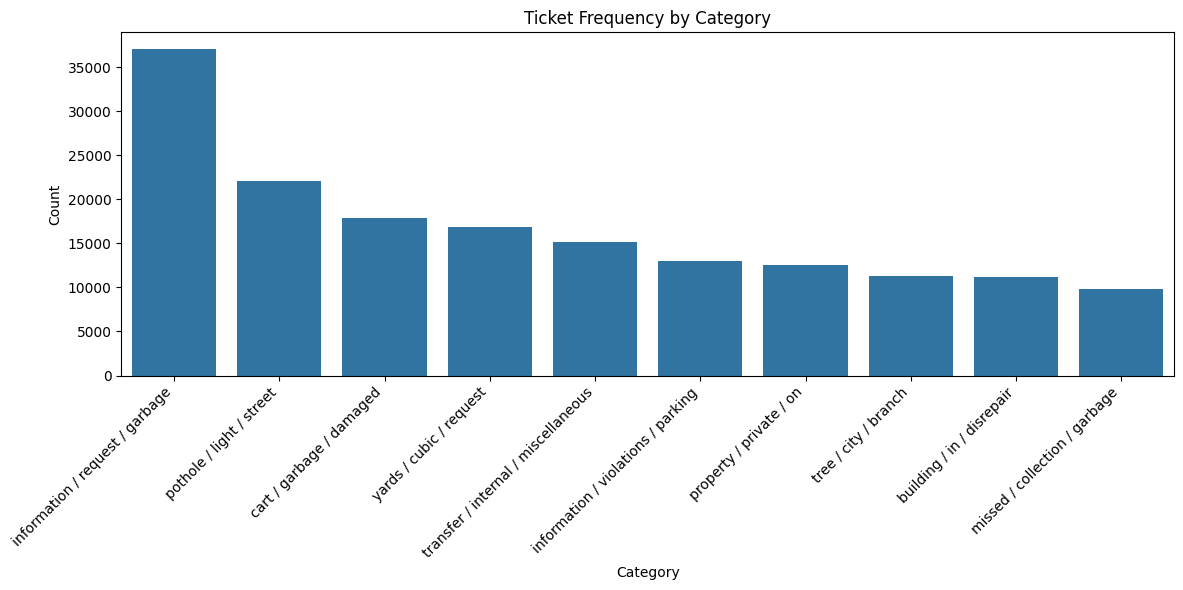

In [29]:
# Plot results
plot_frequency_by_category(df_cat);

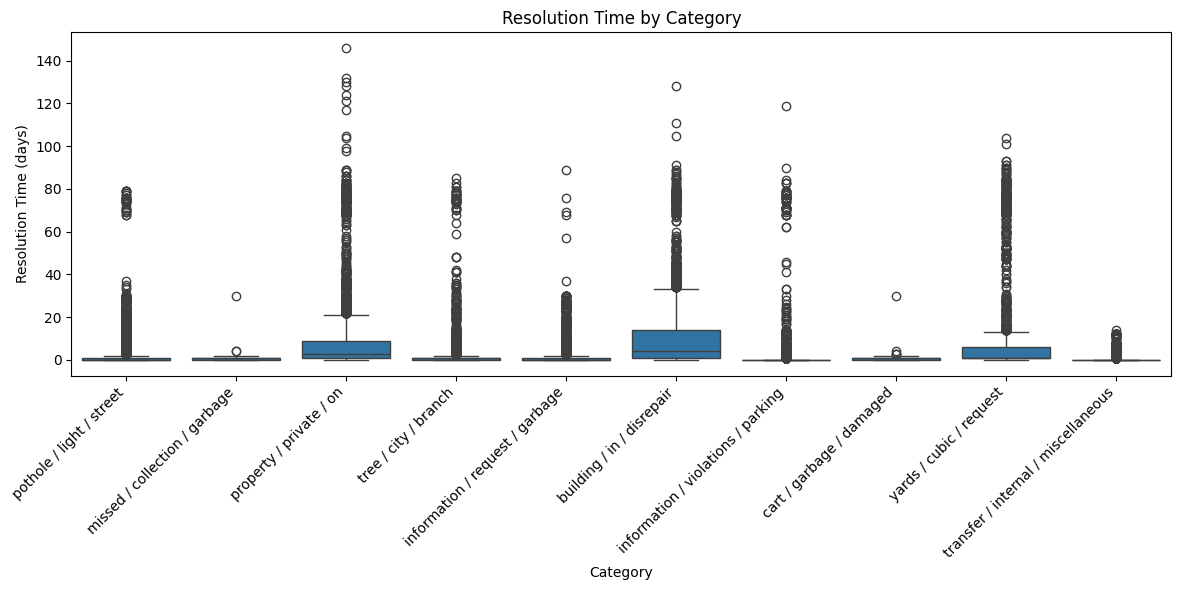

In [30]:
plot_resolution_time_by_category(df_cat);

These plots attempt to organize call reasons by some kind of semantic similarity. Given more time, we might be able to come up with better semantic categories so we can have a high level view of what's happening often and how long it takes to resolve them. 